In [13]:
from css import *
import networkx as nx
import numpy as np
import stim
from collections import defaultdict
import pymatching
import matplotlib.pyplot as plt
from shor_ec import *


do_long_simu = True

# Static case

In [2]:
code = ToricCode(2)
build = CircuitBuilder(code)
circuit = build.memory_exp(3, "X")
circuit.detector_error_model()

stim.DetectorErrorModel('''
    logical_observable L0
    logical_observable L1
    detector D0
    detector D1
    detector D2
    detector D3
    detector D4
    detector D5
    detector D6
    detector D7
    detector D8
    detector D9
    detector D10
    detector D11
    detector D12
    detector D13
    detector D14
    detector D15
    detector D16
    detector D17
    detector D18
    detector D19
    detector D20
    detector D21
    detector D22
    detector D23
    detector D24
    detector D25
    detector D26
    detector D27
    detector D28
    detector D29
    detector D30
    detector D31
    logical_observable L0
    logical_observable L1
''')

## Circuit Level noise threshold experiment with pymatching

In [29]:
def decode_pymatching_batch(circ, n_shots):
    dem = circ.detector_error_model()
    syndrome, logicals = circ.compile_detector_sampler().sample(n_shots,separate_observables = True)
    matching = pymatching.Matching.from_detector_error_model(dem)
    pred_obs = matching.decode_batch(syndrome)
    return np.sum(pred_obs != logicals, axis=0) / pred_obs.shape[0]


if do_long_simu:
    d_list = [5, 9, 13, 15]
    p_list = np.linspace(0.004, 0.01, num=10)
    # n_shots = 256 * 100
    n_shots = 10000
    results = {}
    for d in d_list:
        results[d] = []
        code = SurfaceCode(d)
        for p in p_list:
            print(f"d={d}, p={p}",  end="\r")
            build = NoisyCircuitBuilder(code, p, p)
            # circ = build.memory_exp(d, "X")
            circ = build.memory_exp(d, "Z")
            errors = decode_pymatching_batch(circ, n_shots)
            results[d].append(errors)


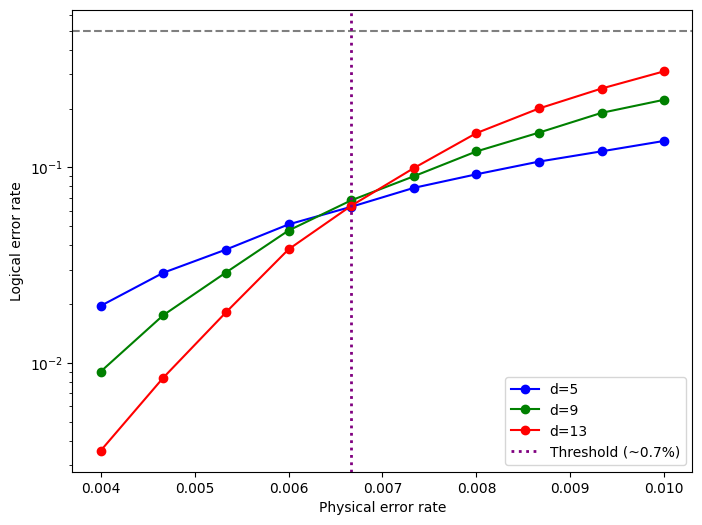

In [25]:
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r']

for d, color in zip(d_list, colors):
    plt.plot(p_list, results[d], 
             'o-', color=color, label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
threshold_p = 0.00666
plt.axvline(x=threshold_p, color='purple', linestyle=':', linewidth=2, 
            label=f"Threshold (~{threshold_p*100:.1f}%)")

# plt.title('Double erasure static SEC')
# plt.ylim(1e-4, 1)
plt.legend()
plt.yscale('log')
# plt.savefig("double_erasure_static_SEC_10percent.eps")
plt.show()

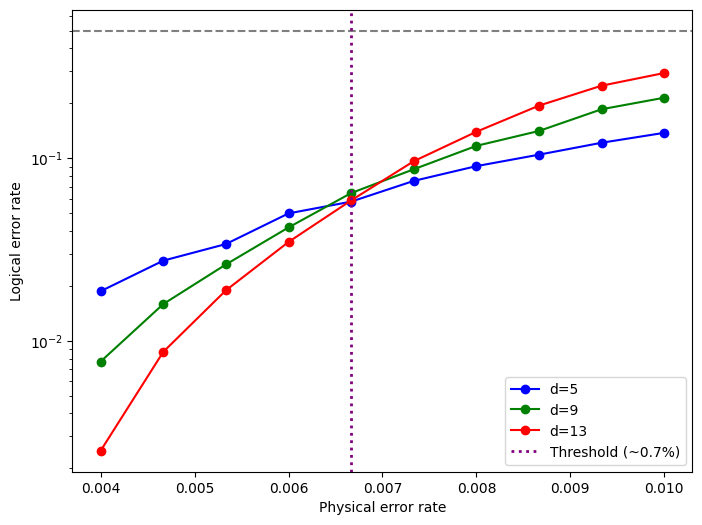

In [30]:
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r']

for d, color in zip(d_list, colors):
    plt.plot(p_list, results[d], 
             'o-', color=color, label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
threshold_p = 0.00666
plt.axvline(x=threshold_p, color='purple', linestyle=':', linewidth=2, 
            label=f"Threshold (~{threshold_p*100:.1f}%)")

# plt.title('Double erasure static SEC')
# plt.ylim(1e-4, 1)
plt.legend()
plt.yscale('log')
# plt.savefig("double_erasure_static_SEC_10percent.eps")
plt.show()


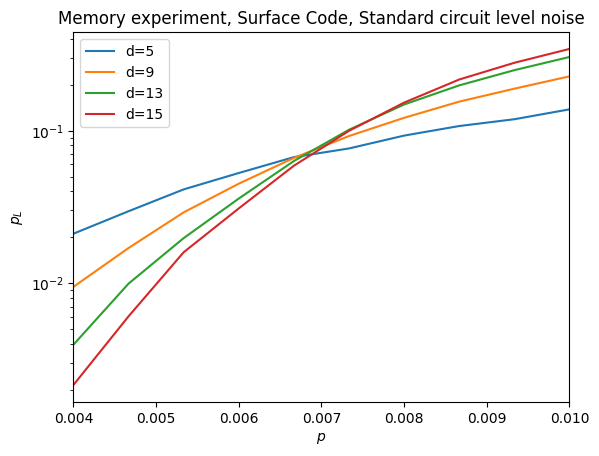

In [4]:
if do_long_simu:
    fig, ax = plt.subplots(1)
    for d in d_list:
        ax.plot(p_list, results[d], label=f"d={d}")
    ax.legend()
    ax.set(
        xlim=[p_list.min(), p_list.max()],
        xlabel=r'$p$',
        ylabel=r'$p_L$',
        title='Memory experiment, Surface Code, Standard circuit level noise',
        yscale="log"
    )

In [5]:
code = ToricCode(3)
n_shots = 256
p=0.002
build = NoisyCircuitBuilder(code, p, p)
circ = build.memory_exp(d, "X")
errors = decode_pymatching_batch(circ, n_shots)
print(errors)

[0.0234375 0.015625 ]


## Erasure-only type experiment with Z_ERROR(0.5) CZ

In [26]:
if do_long_simu:

    d_list = [3, 5, 7]
    p_list = np.linspace(0.0, 0.2, num=10)
    n_shots = 1000
    results_era = {}
    for d in d_list:
        results_era[d] = []
        code = SurfaceCode(d)
        for p in p_list:
            print(f"d={d}, p={p}",  end="\r")
            build = HeraldedNoiseCircuitBuilder(code, p)
            res = 0
            for _ in range(n_shots):
                circ = build.memory_exp(d, "X")
                errors = decode_pymatching_batch(circ, 1)
                res += errors
            results_era[d].append(res / n_shots)


KeyboardInterrupt: 

In [12]:
p_list

array([0.        , 0.02222222, 0.04444444, 0.06666667, 0.08888889,
       0.11111111, 0.13333333, 0.15555556, 0.17777778, 0.2       ])

In [ ]:
# np.savez('threshold_static_double_erasure_surfacecode.npz', 
#          d_list=d_list, 
#          p_list=p_list, 
#          results_era=results_era)

In [2]:
data = np.load('threshold_static_double_erasure_surfacecode.npz', allow_pickle=True)
distances = data['d_list']
noise_rates = data['p_list']
logical_error_rates = data['results_era'].item()  # Note the .item() call for dictionaries

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


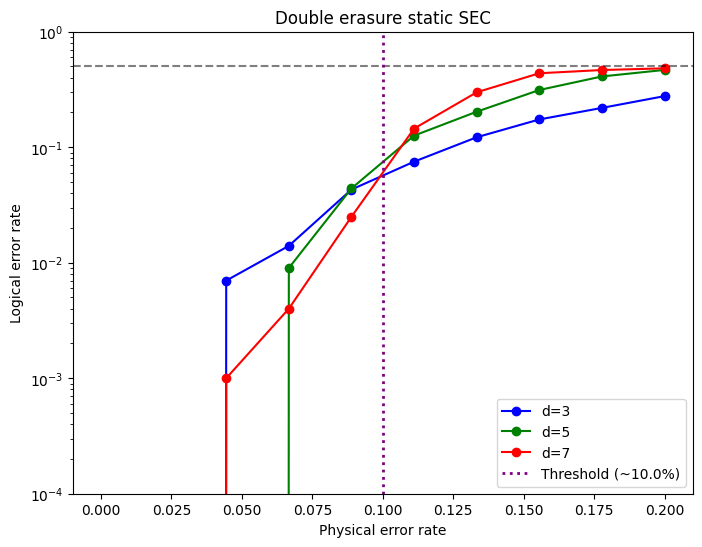

In [27]:
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r']

for d, color in zip(distances, colors):
    plt.plot(noise_rates, logical_error_rates[d], 
             'o-', color=color, label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
threshold_p = 0.1  
plt.axvline(x=threshold_p, color='purple', linestyle=':', linewidth=2, 
            label=f"Threshold (~{threshold_p*100:.1f}%)")

plt.title('Double erasure static SEC')
plt.ylim(1e-4, 1)
plt.legend()
plt.yscale('log')
plt.savefig("double_erasure_static_SEC_10percent.eps")
plt.show()

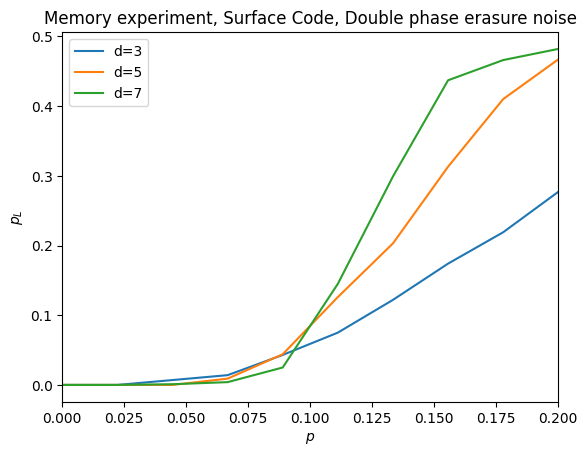

In [8]:
if do_long_simu:
    fig, ax = plt.subplots(1)
    for d in d_list:
        ax.plot(p_list, results_era[d], label=f"d={d}")
    ax.legend()
    ax.set(
        xlim=[p_list.min(), p_list.max()],
        # ylim=[0, 0.2],
        xlabel=r'$p$',
        ylabel=r'$p_L$',
        title='Memory experiment, Surface Code, Double phase erasure noise',
        # yscaleµ="log"
    )

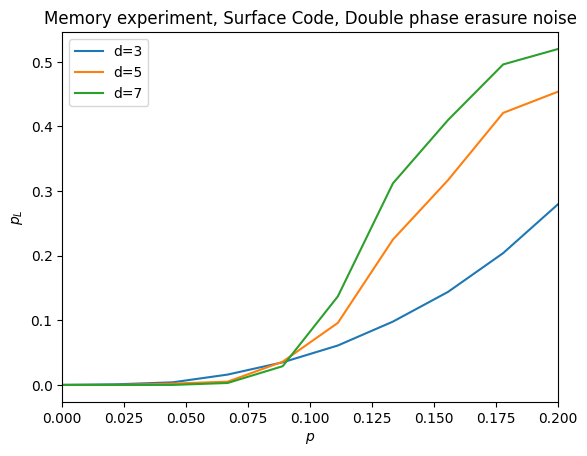

In [11]:
if do_long_simu:
    fig, ax = plt.subplots(1)
    for d in d_list:
        ax.plot(p_list, results_era[d], label=f"d={d}")
    ax.legend()
    ax.set(
        xlim=[p_list.min(), p_list.max()],
        # ylim=[0, 0.2],
        xlabel=r'$p$',
        ylabel=r'$p_L$',
        title='Memory experiment, Surface Code, Double phase erasure noise',
        # yscaleµ="log"
    )

In [31]:
d_list = [3, 5, 7]
p_list = np.linspace(0.0, 0.2, num=10)
for d in d_list:
	for p in p_list:
		print(f"d={d}, p={p}",  end="\r")

In [32]:
for d in d_list:
    for p in p_list:
        print(f"d={d}, p={p:.6f}", end="\r")
print()  # ensures final value stays visible


d=7, p=0.200000


In [33]:
code = SurfaceCode(3)
p = 0.1
build = HeraldedNoiseCircuitBuilder(code, p)
circ = build.memory_exp(d, "Z")


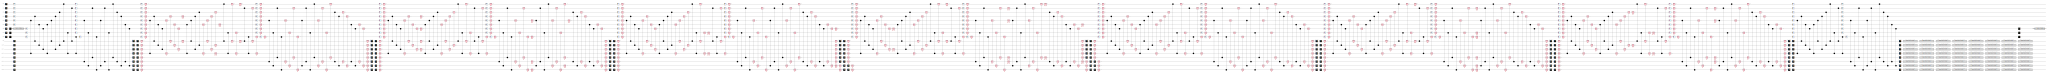

In [7]:
circ.diagram("timeline-svg")

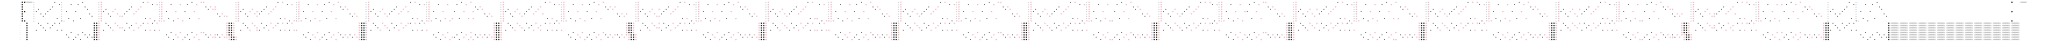

In [34]:
circ.diagram("timeline-svg")